In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=32.1s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Traist association

In [7]:
trait_list = ['PASS_MDD_Wray2018', 'PASS_ADHD_Demontis2018', 'PASS_SCZvsBD_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018', 
              'PASS_Depression_Nagel2018', 'PASS_Neuroticism_Nagel2018', 'PASS_Worry_Nagel2018',
              'PASS_Intelligence_SavageJansen2018', 'PASS_Alzheimers_Jansen2019', 'PASS_Insomnia_Jansen2019',
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 'PASS_LargeArteryStroke_Malik2018', 
              'PASS_CardioembolicStroke_Malik2018',
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_IBD_deLange2017', 'PASS_UC_deLange2017', 'PASS_Crohns_Disease', 
              'PASS_Type_1_Diabetes', 'UKB_460K.disease_T2D']

# Known trait-celltype association 
df_annot_assoc = pd.read_excel(DATA_PATH+'/trait_cell_assoc.xlsx')
df_annot_assoc.index = df_annot_assoc['Disease']
df_annot_assoc  = df_annot_assoc.fillna('')

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

dic_geneset = {}
for trait in trait_list: 
    # Find FDR<0.1 genes 
    temp_v = np.absolute(df_geneannot[trait].values)
    temp_v = 1 - sp.stats.norm.cdf(temp_v)
    temp_v = multipletests(temp_v, method='fdr_bh')[1]
    gene_list = list(df_geneannot.index[temp_v<0.1])
    dic_geneset[trait] = gene_list.copy()
    print('# %-40s n_gene=%d'%(trait, len(gene_list)))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_MDD_Wray2018                        n_gene=128
# PASS_ADHD_Demontis2018                   n_gene=236
# PASS_SCZvsBD_Ruderfer2018                n_gene=271
# PASS_BipolarDisorder_Ruderfer2018        n_gene=687
# PASS_Depression_Nagel2018                n_gene=520
# PASS_Neuroticism_Nagel2018               n_gene=2031
# PASS_Worry_Nagel2018                     n_gene=1701
# PASS_Intelligence_SavageJansen2018       n_gene=3481
# PASS_Alzheimers_Jansen2019               n_gene=299
# PASS_Insomnia_Jansen2019                 n_gene=532
# PASS_AdultOnsetAsthma_Ferreira2019       n_gene=209
# PASS_Coronary_Artery_Disease             n_gene=165
# PASS_LargeArteryStroke_Malik2018         n_gene=25
# PASS_CardioembolicStroke_Malik2018       n_gene=54
# PASS_HDL                                 n_gene=540
# PASS_LDL                                 n_gene=465
# PASS_Rheumatoid_Arthritis                n_gene=287
# PASS_Lupus                      

In [8]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [77]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in trait_list:
    
    md.score_cell(data_facs_ct, dic_geneset[trait], suffix='',
                  trs_opt='vst', ctrl_opt='mean_match',
                  n_ctrl=5, n_genebin=200, flag_correct_background=True,
                  return_list=['trs_tp','trs_ep'], verbose=False)
    dic_trs['%s;tp'%(trait)] = data_facs_ct.obs['trs_tp'].values.copy()
    dic_trs['%s;ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_MDD_Wray2018                        time=5.0s
#PASS_ADHD_Demontis2018                   time=10.2s
#PASS_SCZvsBD_Ruderfer2018                time=15.6s
#PASS_BipolarDisorder_Ruderfer2018        time=21.5s
#PASS_Depression_Nagel2018                time=27.2s
#PASS_Neuroticism_Nagel2018               time=35.7s
#PASS_Worry_Nagel2018                     time=43.4s
#PASS_Intelligence_SavageJansen2018       time=54.7s
#PASS_Alzheimers_Jansen2019               time=60.2s
#PASS_Insomnia_Jansen2019                 time=66.0s
#PASS_AdultOnsetAsthma_Ferreira2019       time=71.2s
#PASS_Coronary_Artery_Disease             time=76.3s
#PASS_LargeArteryStroke_Malik2018         time=80.7s
#PASS_CardioembolicStroke_Malik2018       time=85.2s
#PASS_HDL                                 time=91.1s
#PASS_LDL                                 time=96.8s
#PASS_Rheumatoid_Arthritis                time=102.2s
#PASS_Lupus                               time=107.7s
#PASS_IBD_deLange2017                     tim

/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


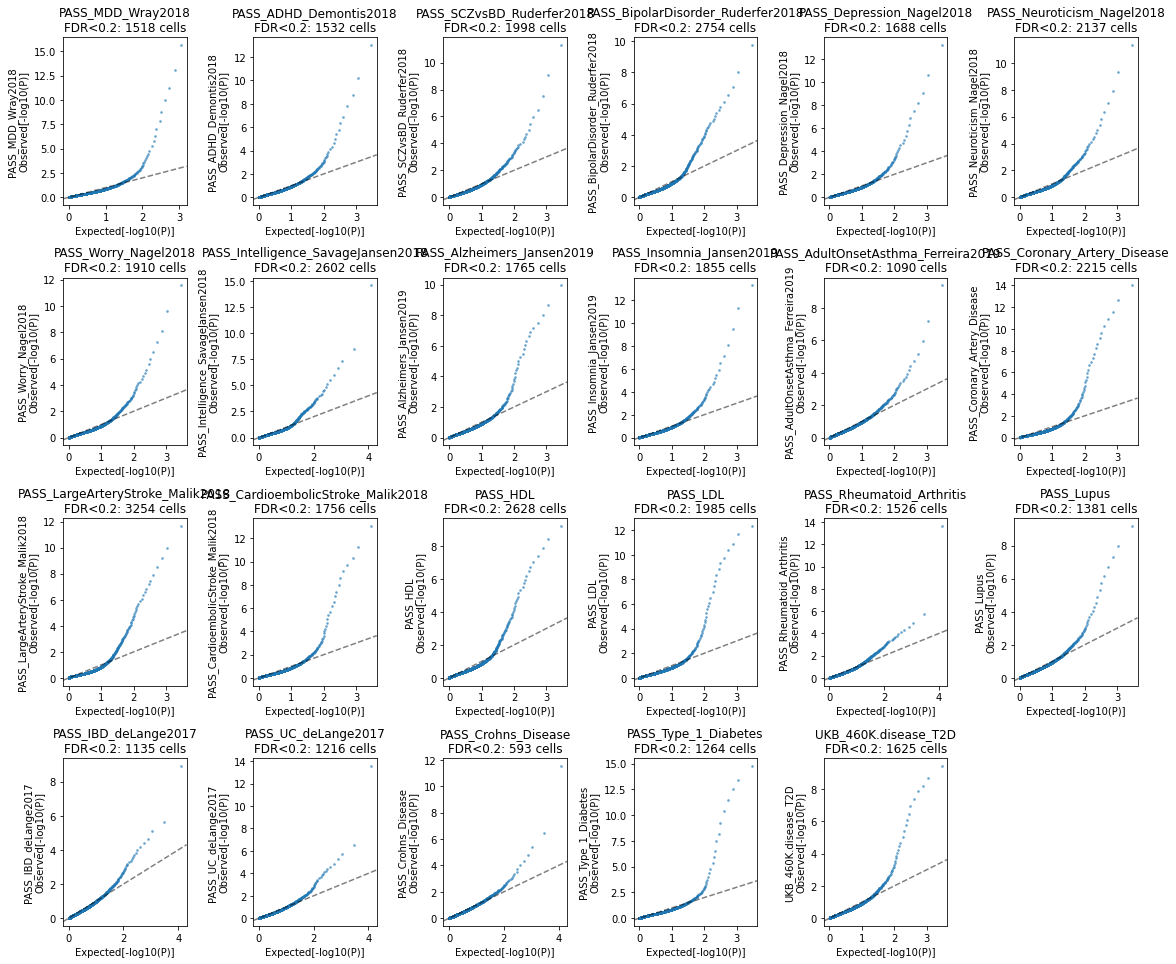

/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


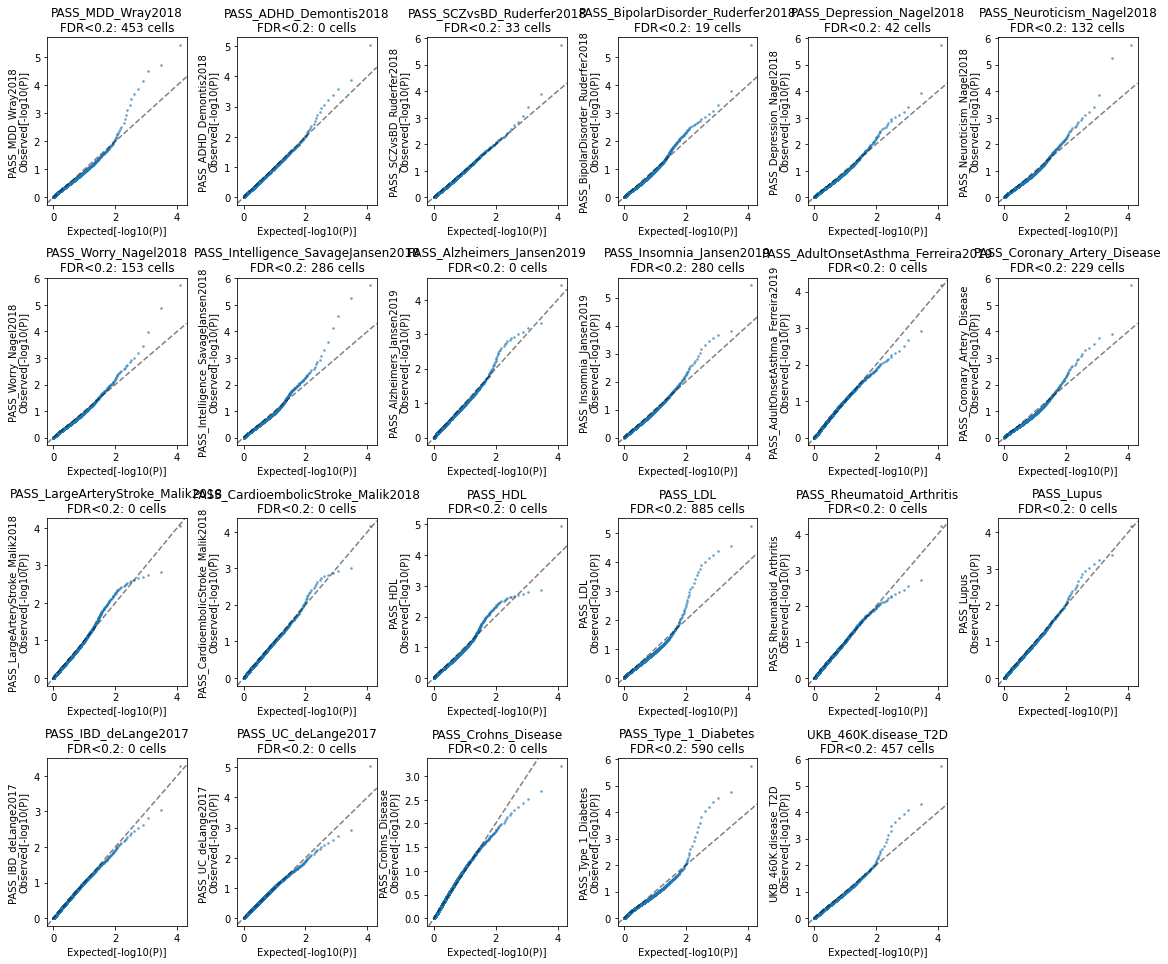

In [78]:
# QQ-plot 
plot_config_list = ['tp', 'ep']
plot_trait_list = trait_list

normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)

for i_config,config in enumerate(plot_config_list):
    plt.figure(figsize=[16, 2+3*len(plot_trait_list)/6])
    for i_trait,trait in enumerate(plot_trait_list): 
        
        v_p = dic_trs['%s;%s'%(trait,config)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(np.ceil(len(plot_trait_list)/6), 6,i_trait+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        plt.title('%s\nFDR<0.2: %d cells'%(trait,(v_fdr<0.2).sum()))
        plt.ylabel('%s\nObserved[-log10(P)]'%trait)
        plt.xlabel('Expected[-log10(P)]')
        
    plt.tight_layout()
    plt.savefig('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/result/trait_assoc_090220/qqplot_%s.pdf'%config)
    plt.show()

In [79]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    v_p = dic_trs['%s;ep'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.2].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.2].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

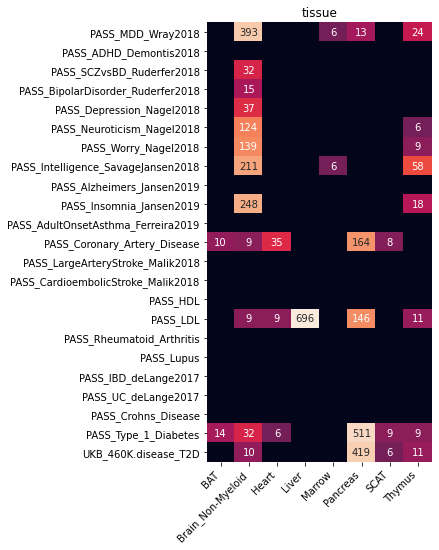

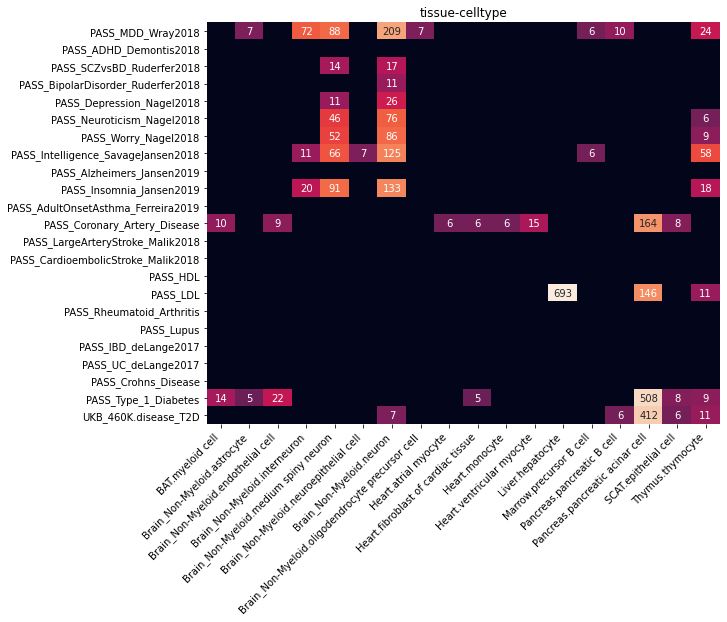

In [80]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>5]
    df_plot = df_plot.T
    df_plot[df_plot<5] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

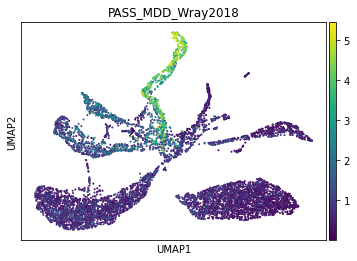

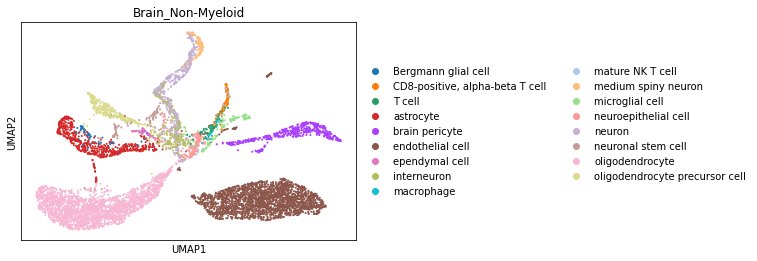

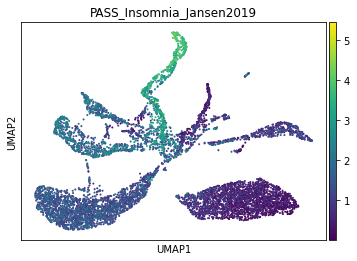

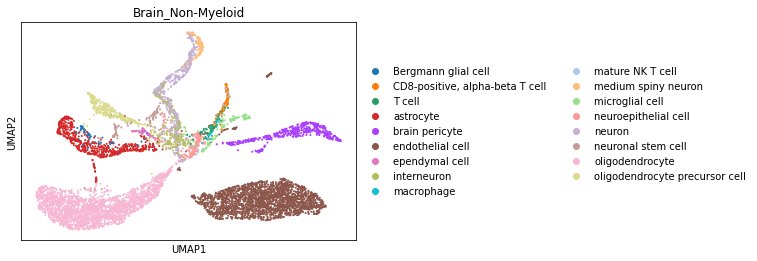

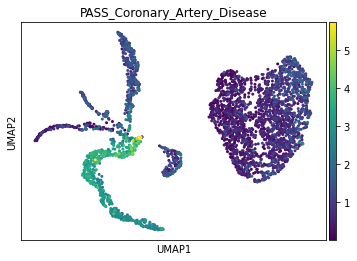

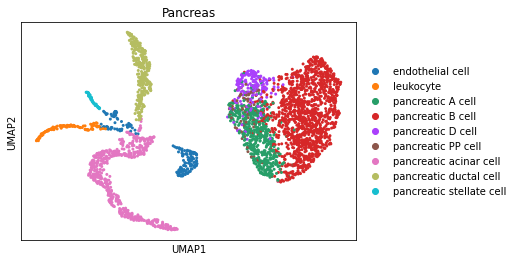

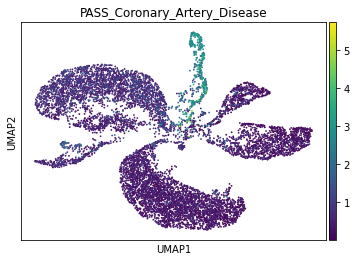

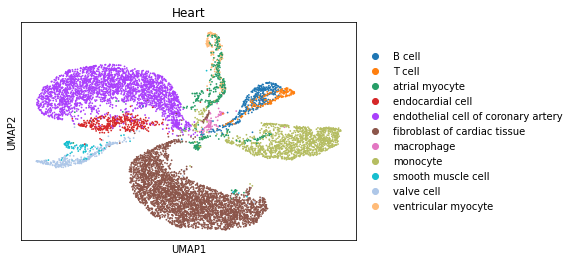

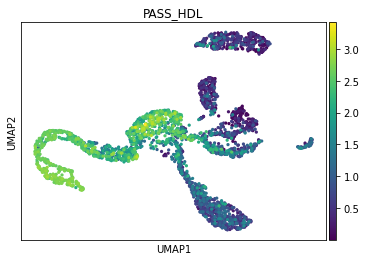

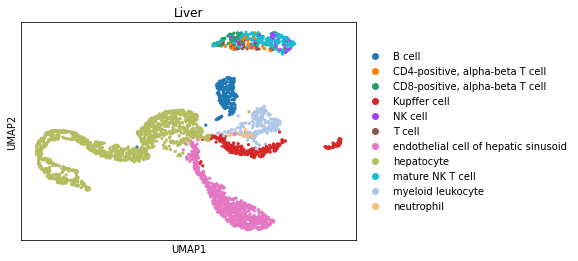

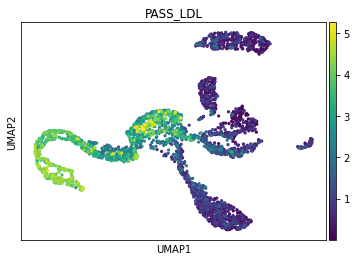

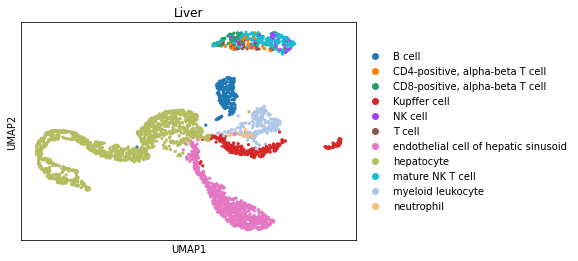

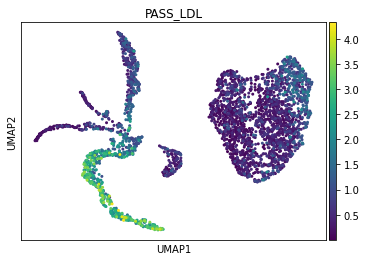

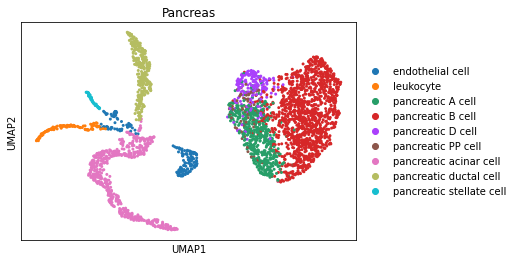

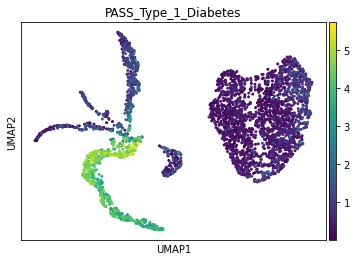

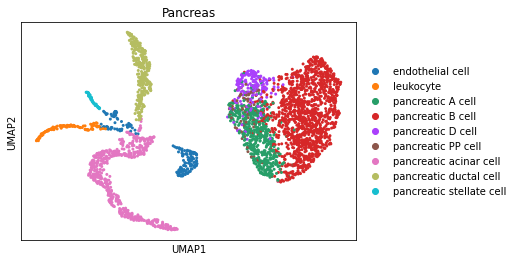

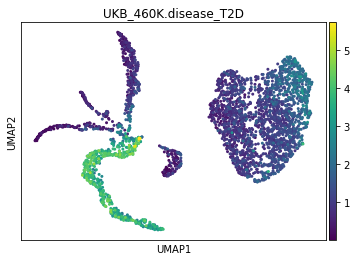

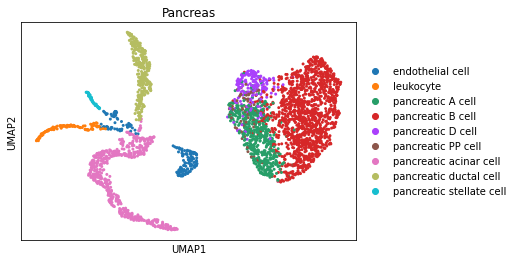

In [85]:
plot_list = [['Brain_Non-Myeloid', 'PASS_MDD_Wray2018'],
             ['Brain_Non-Myeloid', 'PASS_Insomnia_Jansen2019'],
             ['Pancreas', 'PASS_Coronary_Artery_Disease'],
             ['Heart', 'PASS_Coronary_Artery_Disease'],
             ['Liver', 'PASS_HDL'],
             ['Liver', 'PASS_LDL'],
             ['Pancreas', 'PASS_LDL'],
             ['Pancreas', 'PASS_Type_1_Diabetes'],
             ['Pancreas', 'UKB_460K.disease_T2D']]
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index, columns=['ep'], data=dic_trs['%s;ep'%(trait)])
    dic_data_facs[tissue].obs['-log10(p)'] = -np.log10(temp_df.loc[dic_data_facs[tissue].obs.index,'ep'])
    sc.pl.umap(dic_data_facs[tissue], color='-log10(p)', title=trait)
    sc.pl.umap(dic_data_facs[tissue], color='cell_ontology_class', title=tissue)
#     break